In [1]:
# 1.- Libraries import

import pandas as pd
import numpy as np
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation import EvaluatePrequential
import time
from sklearn import metrics
from matplotlib import pyplot as plt

In [2]:
# 2.- Data reading, preprocessing and parameters setting

data = pd.read_csv("cs-training.csv") # Give me some credit data, drop na for easier use
data = data.dropna()

L = 2                                 # Number of instances
I = 750                              # Size of the data block
D = 20                                # Number of dynamic classifiers
eps = 0.25                            # Instance selection ratio

In [3]:
data.shape

(120269, 12)

In [4]:
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


We define 5 functions, most of them as detailed in the paper https://ieeexplore.ieee.org/abstract/document/8706959:

 - **Ensemble**: Main function, as detailed in the paper
 - **CreateNewBaseClassfier**: As detailed in the paper
 - **ReinformentAdjustment**: As detailed in the paper
 - **TrainOnInstance**: As detailed in the paper
 - **predict**: Used for prediction of new values

In [5]:
def ensemble(S,L,I,D,eps):
    
    # 1.- INITIALIZATION
    
    labels = np.asarray(S.iloc[:,1])         # Labels    
    S = np.asarray(S.iloc[:,2:S.shape[1]])   # Data
    
    B = []                                      # Circular array
    U = [[] for i in range(0,L)]                # Resampling buffer
    DCIR = [1/L for i in range(0,L)]            # Class imbalance ratio
    C = []                                      # Classifiers vector
    H = [[0 for i in range(0,D)] for i in range(0,L)]  # Nº of instances of different classes
    ws = 0.5                                    # Static weight
    wd = [1/D for i in range(0,D-1)]            # Dynamic weights

    p = 0                                       # Processed instances counter
    i = 0                                       # Position of circular array
    k = 0                                       # Indicator of dynamic classifiers
    kc = 0                                      # Circular indicator of dynamic classifiers
    
    # Helpers for evaluation of performance
    is_ok = 0

    tp = 0
    fp = 0
    fn = 0
    
    pre = 0
    rec = 0
    pre_pre = 0
    pre_rec = 0
    
    pre_tp = 0
    pre_fp = 0
    pre_fn = 0
    
    f1_score = []
    
    # 2.- PROCESS
    
    for j in range(0, len(S)):
        
        xnew = S[j]
        p = p + 1
        if (p%(I*D) == 0):
            print("")
            print("Instances through stream: ", p)
            print("Acc overall: ", is_ok/(j-I))
            print("Micro-F1 score evaluating model at every new point and calculated every ", I, " examples")
            print("F1 score: ", f1_score[-1])  
            print("")
        
        # 2.1.- FIRST INSTANCES
        if (p < I):
            B.append(xnew)
        elif (p == I):
            B.append(xnew)
            [Cnew, H, U, ws, wd] = CreateNewBaseClassfier(eps, B, U, I, L, D, C, H, wd, ws, k, kc, DCIR, labels)
            C.append(Cnew)
            k = 1
            kc = 1
        
        # 2.2.- MIDDLE INSTANCES
        else:
            #Evaluating            
            sol = predict(S[j,:], C, ws, wd)[0]
            
            if sol == labels[j]:
                is_ok += 1
                if labels[j] == 1:
                    tp += 1
            elif sol != labels[j] and labels[j] == 1:
                fn += 1
            elif sol != labels[j] and labels[j] == 0:
                fp += 1

            
            i = (p-1)%I
            
            [B, C, ws, wd] = TrainOnInstance(xnew, i, L, D, B, C, wd, ws, DCIR[labels[p-I-1]], labels[p-I-1])
            i = (i + 1)%I
            if (i == 0):
                k = k+1
                kc = k%D
                
                pre_tp = pre_tp + tp
                pre_fp = pre_fp + fp
                pre_fn = pre_fn + fn
                
                
                if (pre_tp + pre_fp == 0) and (pre_tp + pre_fn == 0):
                    f1_score.append("All cases true negatives so far")
                elif (pre_tp + pre_fp == 0):
                    f1_score.append("No true positives neither false positives so far")
                elif (pre_tp + pre_fn == 0):
                    f1_score.append("No true positives neither false negatives so far")
                elif pre_tp == 0:
                    f1_score.append("No true positives so far")
                else:
                    pre = (pre_tp)/(pre_tp + pre_fp)
                    rec = (pre_tp)/(pre_tp + pre_fn)
                    
                    f1_score.append((2 * pre * rec)/(pre + rec))

                tp = 0
                fp = 0
                fn = 0
                
                [Ck, H, U, ws, wd] = CreateNewBaseClassfier(eps, B, U, I, L, D, C, H, wd, ws, k, kc, DCIR, labels)
                if k > D:

                    C[1:len(C)-1] = C[2::]
                    C[-1] = Ck


                    ws = 1/2
                    wd[0:D-2] = list(map(lambda x: x * (1-1/D), wd[1:D-1]))
                    wd[-1] = 1/D
                else:
                    C.append(Ck)
                    ws = 1/2
                    wd[0:k-2] = list(map(lambda x: x * (1-1/D), wd[0:k-2]))
                    wd[0] = 1/D

                if k < D:
                    l = k
                else:
                    l = D
                temp = [np.asarray(H[i][1:l+1]) * np.asarray(wd[0:l]) for i in range(0,L)]
                for i in range(0,L):
                    DCIR[i] = np.sum(temp[i])/np.sum(temp)
                    
    # 2.3.- FINAL INSTANCES
    for j in range(0,I-1):
        xnew = B[j]
        [B, C, ws, wd] = TrainOnInstance(xnew, i, L, D, B, C, wd, ws, DCIR[labels[j-I]], labels[len(labels)-I+j])
    
    print("------------END------------")
    print("Instances through stream: ", p)
    print("Acc overall: ", is_ok/(len(data)-I))
    print("Micro-F1 score evaluating model at every new point and calculated every ", I, " examples")
    print("F1 score: ", f1_score[-1])  
    print("")
    plt.plot(f1_score[10::])
    
    return [C,ws,wd]

In [6]:
def CreateNewBaseClassfier(eps, B, U, I, L, D, C, H, wd, ws, k, kc, DCIR, labels):
    
    # 1.- Select top eps*I instances
    Rn = B[0:int(I*eps)]
    Rlabels = labels[0:int(I*eps)]
    
    # 2.- In case is not the first classifier, perform weight adjustment
    if k != 0:
        for i in range(0, len(Rn)):
            [ws,wd] = ReinformentAdjustment(np.asarray([Rn[i]]), L, D, C, wd, ws, DCIR[Rlabels[i]],Rlabels[i])
    
    # 3.- Calculate instance numbers
    for i in range(0,L):
        H[i][kc] = len(np.where(Rlabels[0:int(I*eps)]==i)[0])
    
    # 4.- Create new classifier
    Cnew = HoeffdingTree()
    
    # 5.- In case is not the first classifier, train in previous instances for balance
    if k != 0:
        if (H[0][kc] < int(I*eps/L)) and (len(U[0])>0):
            U0 = np.array(U[0])
            if len(U[0]) >= (int(I*eps/L) - H[0][kc]):
                Cnew.fit(U0[-(int(I*eps/L) - H[1][kc]):], np.asarray([0 for i in range(0, (int(I*eps/L) - H[0][kc]))]))
            else:
                Cnew.fit(U0, np.asarray([0 for i in range(0, len(U[0]))]))
        elif (H[1][kc] < int(I*eps/L)) and (len(U[1])>0):
            U1 = np.array(U[1])
            
            if len(U[1]) >= (int(I*eps/L) - H[1][kc]):
                Cnew.fit(U1[-(int(I*eps/L) - H[1][kc]):], np.asarray([1 for i in range(0, (int(I*eps/L) - H[1][kc]))]))
            else:
                Cnew.fit(U1, np.asarray([1 for i in range(0, len(U[1]))]))
        Cnew.partial_fit(Rn,Rlabels)
            
    else:
        # 6.- Train the new classifier
        Cnew.fit(np.array(Rn), np.array(Rlabels))
    
    # 7.- Adapt the resampling buffer
    for i in range(0,len(Rn)):
        if Rlabels[i] == 0:
            U[0].append(Rn[i])
            if len(U[0])> int(I*eps/L):
                U[0].pop()
        else:            
            U[1].append(Rn[i])
            if len(U[1])> int(I*eps/L):
                U[1].pop()
    
    return [Cnew, H, U, ws, wd]

In [7]:
def  ReinformentAdjustment(x, L, D, C, wd, ws, DCIR, label):
    if (DCIR < 1/L):
        for d in range(1,len(C)):
            if (C[d].predict(x)[0] == label):
                wd[d-1] = wd[d-1]*(1+1/D)
            else:
                wd[d-1] = wd[d-1]*(1-1/D)
        if (C[0].predict(x)[0] == label):
            ws = ws*(1+1/D)
        else:
            ws = ws*(1-1/D)   
    return [ws,wd]

In [8]:
def TrainOnInstance(xnew, i, L, D, B, C, wd, ws, DCIR, label):
    x = np.asarray([B[i]])
    [ws, wd] = ReinformentAdjustment(x, L, D, C, wd, ws, DCIR, label)
    for j in range(0,len(C)):
        if label == 1:
            C[j].partial_fit(x, [label])
        elif (label == 0) and (np.random.rand(1)<0.15):
            C[j].partial_fit(x, [label])
    B[i] = xnew
    return [B, C, ws, wd]

In [9]:
def predict(data, C, ws, wd):
    if len(data.shape) < 2:
        data = np.asarray(data).reshape((data.shape[0], 1))
    else:
        data = np.asarray(data)
    pred = C[0].predict(data)*ws
    for i in range(1, len(C)):
        pred = pred + C[i].predict(data)*wd[i-1]
    for i in range(0, len(pred)):
        if pred[i] >= 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    return pred

Dummy F1 (All 0):  0.9640065293887097
Dummy F1 (All random):  0.12006996064713599
Dummy Acc (All 0):  0.930514097564626
Dummy Acc (All random):  0.49802526004207237

Instances through stream:  15000
Acc overall:  0.9072215594076777
Micro-F1 score evaluating model at every new point and calculated every  750  examples
F1 score:  0.14545454545454545


Instances through stream:  30000
Acc overall:  0.6961263632944716
Micro-F1 score evaluating model at every new point and calculated every  750  examples
F1 score:  0.12963553288704707


Instances through stream:  45000
Acc overall:  0.48823702230558885
Micro-F1 score evaluating model at every new point and calculated every  750  examples
F1 score:  0.1332701346921041


Instances through stream:  60000
Acc overall:  0.5225573427399619
Micro-F1 score evaluating model at every new point and calculated every  750  examples
F1 score:  0.13161131611316115


Instances through stream:  75000
Acc overall:  0.5069024498646446
Micro-F1 score evaluatin

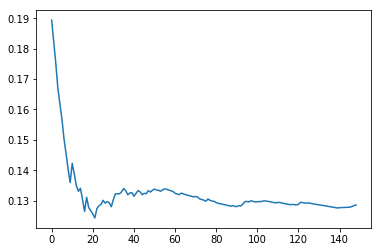

In [10]:
# 4.- Test and metrics
start_time = time.time()
rand = np.random.randint(0,2, size = len(np.asarray(data.iloc[:,1])))
dummy_tp_r = np.logical_and((np.asarray(data.iloc[:,1])   == rand), (np.asarray(data.iloc[:,1]) == 1))
dummy_fp_r = np.logical_and((np.asarray(data.iloc[:,1])   != rand), (np.asarray(data.iloc[:,1]) == 1))
dummy_fn_r = np.logical_and((np.asarray(data.iloc[:,1])   != rand),(np.asarray(data.iloc[:,1]) == 0))
dummy_pre_r = (np.sum(dummy_tp_r)/(np.sum(dummy_tp_r) + np.sum(dummy_fp_r)))
dummy_rec_r = (np.sum(dummy_tp_r))/(np.sum(dummy_tp_r) + np.sum(dummy_fn_r))
dummy_f1_r = (2 * dummy_pre_r * dummy_rec_r)/(dummy_pre_r + dummy_rec_r)

dummy_acc_r = np.sum(np.asarray(data.iloc[:,1]) == rand)/len(np.asarray(data.iloc[:,1]))
dummy_acc = np.sum(np.asarray(data.iloc[:,1]) == 0)/len(np.asarray(data.iloc[:,1]))

dummy_tp = np.asarray(data.iloc[:,1])   == 0
dummy_fp = np.asarray(data.iloc[:,1])   == 2
dummy_fn = np.asarray(data.iloc[:,1])   == 1
dummy_pre = (np.sum(dummy_tp)/(np.sum(dummy_tp) + np.sum(dummy_fp)))
dummy_rec = (np.sum(dummy_tp))/(np.sum(dummy_tp) + np.sum(dummy_fn))
dummy_f1 = (2 * dummy_pre * dummy_rec)/(dummy_pre + dummy_rec)
print("Dummy F1 (All 0): ", dummy_f1)
print("Dummy F1 (All random): ", dummy_f1_r)
print("Dummy Acc (All 0): ", dummy_acc)
print("Dummy Acc (All random): ", dummy_acc_r)





ret = ensemble(data,L,I,D,eps)
end_time = time.time()
print("Total time: ", end_time - start_time)